In [44]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
from scipy.linalg import hankel
import statsmodels.api as sm
import matplotx
plt.style.use(matplotx.styles.aura['dark'])

In [45]:
def trial_xticks(ax, xlocs, yloc=-0.04):
    xlocs = np.array(xlocs)
    ax.set_xticks(xlocs)
    ax.set_xticklabels([])
    ax.tick_params("x", length=17, width=1, which="major")
    ax.set_xlabel("Time", labelpad=10)

    periods = ["S", "Cue", "Delay", "Arm", "Reward"]
    for i in range(5):
        xloc = xlocs[i] + (xlocs[i+1] - xlocs[i]) / 2
        ax.text(
            xloc,
            yloc,
            periods[i],
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
            transform=ax.get_xaxis_transform(),
            rotation=0,
        )
def nll(w, X, y):
    lam = np.exp(X @ w)
    # print(lam.shape)
    return -1 * y.T @ np.log(lam) + lam.sum() - 0.5 * w.T @ w
colors = ['tab:red', 'tab:blue']

In [3]:
with open('test_data_acc_ind_492_0607.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(data.keys())
n_neurons = len(data['spikes'])
print(f'n_neurons: {n_neurons}')


dict_keys(['nCues_RminusL', 'currMaze', 'laserON', 'trialStart', 'trialEnd', 'keyFrames', 'time', 'cueOnset_L', 'cueOnset_R', 'choice', 'trialType', 'spikes', 'timeSqueezedFR'])
n_neurons: 324


trial lengths = 11.529320000000098


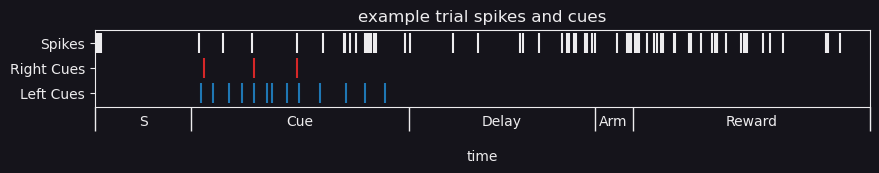

In [4]:
neuron = 10
trial_idx = np.nonzero(data["currMaze"] > 7)[0][18]
trial_start = data["trialStart"][trial_idx]
trial_end = data["trialEnd"][trial_idx]
trial_length = trial_end - trial_start
spikes = data["spikes"][neuron]
spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]
keyframes = data["keyFrames"][trial_idx]
keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
lcue_times = data['cueOnset_L'][trial_idx]
rcue_times = data['cueOnset_R'][trial_idx]
fig, ax = plt.subplots(figsize=(10, 1))
ax.vlines(spikes - trial_start, 2.1, 2.9)
ax.vlines(lcue_times, 0.1, 0.9, colors='tab:blue')
ax.vlines(rcue_times, 1.1, 1.9, colors='tab:red')
ax.set_yticks(np.arange(0.5, 3, 1))
ax.set_yticklabels(['Left Cues', 'Right Cues', 'Spikes'])
trial_xticks(ax, xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
ax.set_xlim([0, trial_length])
ax.set_title("example trial spikes and cues")
ax.set_xlabel("time")
print(f'trial lengths = {trial_end - trial_start}')


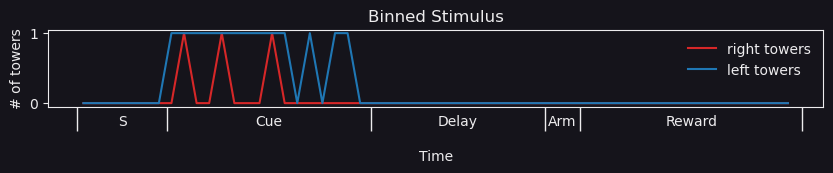

In [5]:
bins = np.arange(0, trial_length, 0.2)
bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")

fig, ax = plt.subplots(figsize=(10, 1))
binned_stimr, _ = np.histogram(rcue_times, bins)
plt.plot(bin_centers, binned_stimr, color=colors[0], label="right towers")
binned_stiml, _ = np.histogram(lcue_times, bins)
plt.plot(bin_centers, binned_stiml, color=colors[1], label="left towers")
trial_xticks(ax, xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
ax.set_ylabel("# of towers")
ax.set_title("Binned Stimulus")
ax.legend()


Text(0.5, 1.0, 'Binned Spikes')

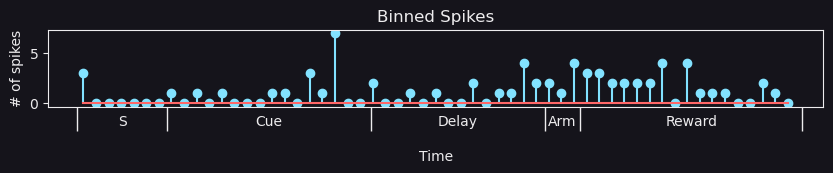

In [6]:
fig, ax = plt.subplots(figsize=(10, 1))
binned_spikes, _ = np.histogram(spikes-trial_start, bins)
plt.stem(bin_centers, binned_spikes, label="spikes")
trial_xticks(ax, xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
ax.set_ylabel("# of spikes")
ax.set_title("Binned Spikes")


(57, 10)

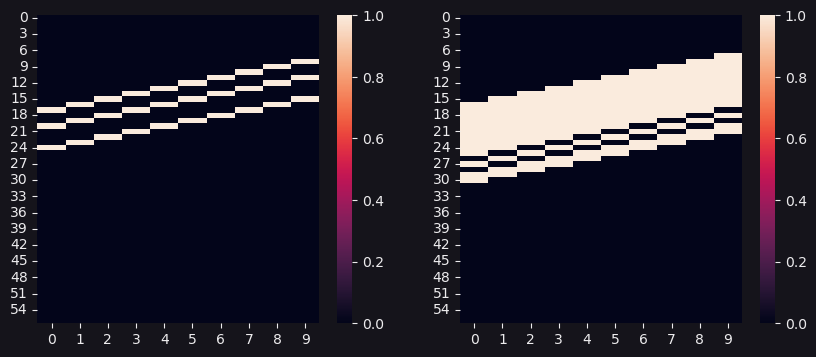

In [7]:
filt_len = 10
padded_stimr = np.pad(binned_stimr, (filt_len-1, 0), constant_values=(0, 0))
X_sr = hankel(padded_stimr[:-filt_len+1], padded_stimr[-filt_len:])
padded_stiml = np.pad(binned_stiml, (filt_len-1, 0), constant_values=(0, 0))
X_sl = hankel(padded_stiml[:-filt_len+1], padded_stiml[-filt_len:])
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(X_sr, ax=axs[0])
sns.heatmap(X_sl, ax=axs[1])
X_sr.shape

(57, 10)

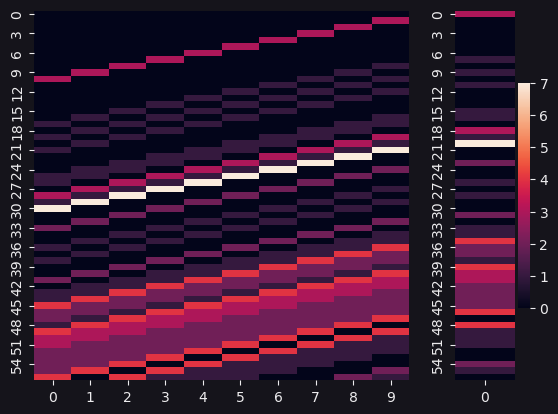

In [8]:
padded_spikes = np.pad(binned_spikes[:-1], (filt_len, 0), constant_values=(0, 0))
X_sp = hankel(padded_spikes[:-filt_len+1], padded_spikes[-filt_len:])
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]})
sns.heatmap(X_sp, ax=axs[0], cbar=False)
sns.heatmap(binned_spikes[:, np.newaxis], ax=axs[1])
X_sp.shape

# Fitting poisson glm to single neuron on all trials

In [61]:
# constructing design matrix with all trials

neuron = 11
trial_indices = np.nonzero(data["currMaze"] > 7)[0]
print(f'number of trials: {trial_indices.size}')
X = []
y = []
filt_len = 25
bin_size = 0.35

for trial_idx in trial_indices:
    trial_start = data["trialStart"][trial_idx]
    trial_end = data["trialEnd"][trial_idx]
    trial_length = trial_end - trial_start
    spikes = data["spikes"][neuron]
    spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]
    keyframes = data["keyFrames"][trial_idx]
    keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
    lcue_times = data["cueOnset_L"][trial_idx]
    rcue_times = data["cueOnset_R"][trial_idx]

    bins = np.arange(0, trial_length, bin_size)
    bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")

    binned_stimr, _ = np.histogram(rcue_times, bins)
    binned_stiml, _ = np.histogram(lcue_times, bins)
    binned_spikes, _ = np.histogram(spikes - trial_start, bins)
    binned_ev = np.cumsum(binned_stimr) - np.cumsum(binned_stiml)

    padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
    X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
    padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
    X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
    padded_ev = np.pad(binned_ev, (filt_len - 1, 0), constant_values=(0, 0))
    X_ev = hankel(padded_ev[: -filt_len + 1], padded_stiml[-filt_len:])
    
    padded_spikes = np.pad(binned_spikes[:-1], (filt_len, 0), constant_values=(0, 0))
    X_sp = hankel(padded_spikes[: -filt_len + 1], padded_spikes[-filt_len:])

    X.append(np.hstack((X_sr, X_sl, X_sp, np.ones((X_sp.shape[0], 1)))))
    y.append(binned_spikes[:, np.newaxis])

X = np.vstack(X)
y = np.vstack(y)

#, 


number of trials: 233


LL: -7021.023332028075


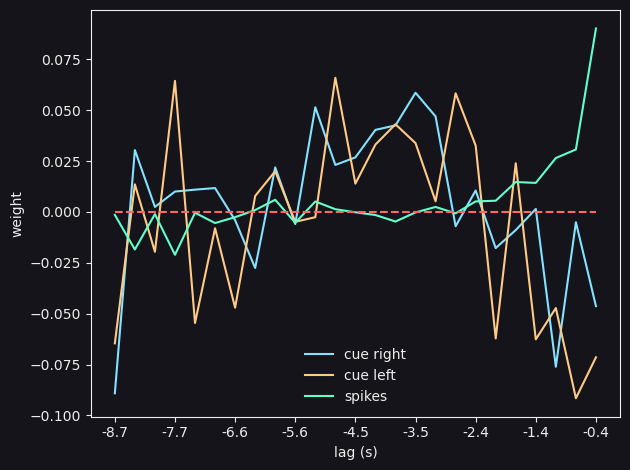

In [62]:
weights = np.zeros(y.shape[0]) * 0.0001
weights[:1000] = 1

glm = sm.GLM(endog=y, exog=X, family=sm.families.Poisson())#, freq_weights=weights)

res = glm.fit(max_iter=1000, tol=1e-6, tol_criterion="params")

w = res.params
rate = np.exp(X@w)

LL = y.T @ np.log(rate) - rate.sum()
print(f"LL: {LL[0]}")

fig, ax = plt.subplots()
ax.plot(w[:-1].reshape(-1, filt_len).T, label=["cue right", "cue left", "spikes"])
ax.plot(np.arange(filt_len), np.zeros(filt_len), "--")
ax.legend()
xlabels = np.round(
    -1 * np.arange(bin_size, filt_len * bin_size + bin_size, bin_size)[::-3], 1
)
ax.set_xticks(np.arange(filt_len)[::3], xlabels)
ax.set_xlabel("lag (s)")
ax.set_ylabel("weight")
plt.tight_layout()




233


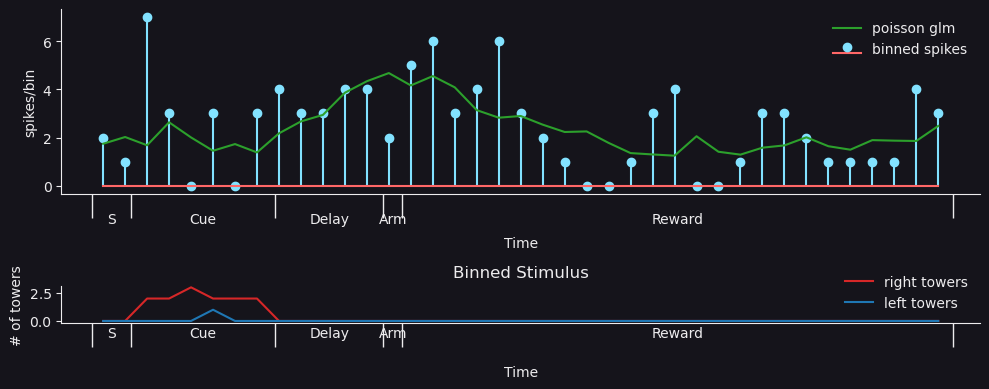

In [43]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={"height_ratios": [5, 1]})


sort_idx = np.argsort(data['nCues_RminusL'][data["currMaze"] > 7])  # ordered index of (lots of left cues) -> (lots of right cues)
plot_trial = sort_idx[-1]
print(sort_idx.size)

trial_idx = np.nonzero(data["currMaze"] > 7)[0][plot_trial]
trial_start = data["trialStart"][trial_idx]
trial_end = data["trialEnd"][trial_idx]
trial_length = trial_end - trial_start
spikes = data["spikes"][neuron]
spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]
keyframes = data["keyFrames"][trial_idx]
keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
lcue_times = data["cueOnset_L"][trial_idx]
rcue_times = data["cueOnset_R"][trial_idx]
bins = np.arange(0, trial_length, bin_size)
bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")
binned_stimr, _ = np.histogram(rcue_times, bins)
binned_stiml, _ = np.histogram(lcue_times, bins)
binned_spikes, _ = np.histogram(spikes - trial_start, bins)

padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])

padded_spikes = np.pad(binned_spikes[:-1], (filt_len, 0), constant_values=(0, 0))
X_sp = hankel(padded_spikes[: -filt_len + 1], padded_spikes[-filt_len:])

X_plot = np.hstack((X_sr, X_sl, X_sp, np.ones((X_sp.shape[0], 1))))
y_plot = binned_spikes[:, np.newaxis]
# y_pred = np.exp(pGLM_const + X_plot[:, :-1] @ pGLM_filt)
y_pred = np.exp(X_plot @ w)

axs[0].stem(bin_centers, y_plot, label="binned spikes")
axs[0].plot(bin_centers, y_pred, color="tab:green", label="poisson glm")
trial_xticks(axs[0], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
axs[0].set_ylabel('spikes/bin')
axs[0].legend()


axs[1].plot(bin_centers, binned_stimr, color=colors[0], label="right towers")
axs[1].plot(bin_centers, binned_stiml, color=colors[1], label="left towers")
trial_xticks(axs[1], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
axs[1].set_ylabel("# of towers")
axs[1].set_title("Binned Stimulus")
axs[1].legend()
plt.tight_layout()
sns.despine()


<AxesSubplot:>

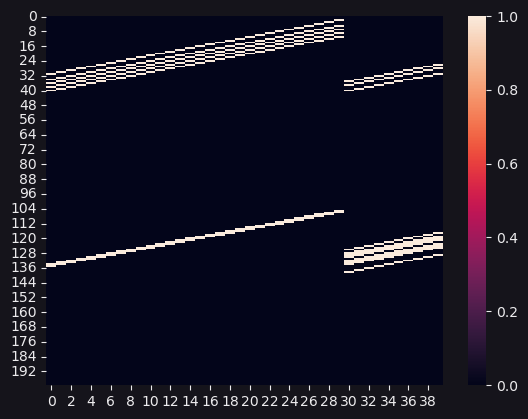

In [ ]:
sns.heatmap(X[:200, :40])

In [182]:
sort_idx = np.argsort(data['nCues_RminusL'])
data['nCues_RminusL'][sort_idx[2]]

-13.0

In [63]:
from scipy.stats import dirichlet

dist = dirichlet((1, 1, 5))
samp = dist.rvs(1) 
print(samp)
samp.sum()

[[0.18567232 0.00554402 0.80878366]]


0.9999999999999999

In [57]:
t_init = np.array([5, 1, 1])
np.roll(t_init, 2)

array([1, 1, 5])